In [10]:
# 중심축 기반 부피 계산
import trimesh
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares

# 상수 정의


THICKNESS = 0.0003 ##단면의 두께
MIN_POINTS_PER_SLICE = 10 ##원 검출 시 최소 포인트 수
MAX_CONSECUTIVE_FAILURES = 10 ##원 검출 시 최대 연속 실패 횟수
MIN_RADIUS, MAX_RADIUS = 0.02, 0.1 ##원 검출 시 최소 및 최대 반지름
MIN_POINTS_PER_METER = 50.0 ##중심축 기반 원검출시 최소 포인트 수
MIN_ANGLE_COVERAGE_THRESHOLD = 0.2  # 원 검출 시 최소 각도 커버리지 (20% 이상)



# 새로운 바닥 검출 파라미터
BOTTOM_SEARCH_RADIUS = 0.02   # 중심축으로부터 2cm 범위 (20mm)
BOTTOM_GRID_SIZE = 20          # 그리드 20x20 = 400개 셀
MIN_BOTTOM_GRID_COVERAGE = 0.2  # 바닥 검출을 위한 최소 그리드 커버리지 (0.0 ~ 1.0, 10% 이상)
BOTTOM_SEARCH_RATIO = 0.3     # 하위 30%만 바닥 검출

# 중심축 선정을 위한 지표 가중치
WEIGHT_PPM = 0
WEIGHT_ANGLE_COVERAGE = 0.5
WEIGHT_GRID_COVERAGE = 0.5
WEIGHT_INLIER_RATIO = 0

# 그리드 기반 커버리지 계산 파라미터
GRID_SIZE = 40  
INNER_RADIUS_RATIO_FOR_GRID = 0.8  # 원 반지름의 60% 이내

# 각도 커버리지 계산 파라미터
ANGLE_SEGMENTS = 180  

# GLB 로드 및 z축이 중력방향이 되도록 scene을 회전하는 함수
def load_and_align_scene(filepath):
    scene = trimesh.load(filepath)
    A = np.array(scene.metadata.get('hf_alignment', np.eye(4))).reshape(4, 4)
    gravity = (A[:3, :3] @ np.array([[1,0,0],[0,-1,0],[0,0,-1]]) @ np.array([0,1,0]))
    gravity = gravity / np.linalg.norm(gravity)
    
    R = Rotation.align_vectors([[0, 0, 1]], [gravity])[0]
    T = np.eye(4)
    T[:3, :3] = R.as_matrix()
    for geom in scene.geometry.values():
        geom.apply_transform(T)
    
    for geometry in scene.geometry.values():
        if isinstance(geometry, trimesh.PointCloud):
            return geometry.vertices
    return None


# 원 검출 함수들

def calculate_ppm(inlier_points, radius):
    """둘레당 인라이너 포인트 수 계산 (Points Per Meter)"""
    if radius <= 0:
        return 0.0
    circumference = 2 * np.pi * radius
    n_inliers = len(inlier_points)
    ppm = n_inliers / circumference if circumference > 0 else 0
    return ppm

def calculate_angle_coverage(inlier_points, center):
    """인라이너가 원 둘레를 커버하는 정도 계산 (0.0 ~ 1.0)"""
    if len(inlier_points) == 0:
        return 0.0
    
    # 각 포인트의 각도 계산
    relative_points = inlier_points - center
    angles = np.arctan2(relative_points[:, 1], relative_points[:, 0])
    
    # 각도를 0~2π 범위로 정규화
    angles = (angles + 2 * np.pi) % (2 * np.pi)
    
    # 각도 구간으로 나누기
    segment_size = 2 * np.pi / ANGLE_SEGMENTS
    segment_indices = (angles / segment_size).astype(int)
    segment_indices = np.clip(segment_indices, 0, ANGLE_SEGMENTS - 1)
    
    # 커버된 구간 수 계산
    covered_segments = len(np.unique(segment_indices))
    coverage = covered_segments / ANGLE_SEGMENTS
    
    return coverage

def calculate_grid_coverage(points_2d, center, radius, inner_radius_ratio=INNER_RADIUS_RATIO_FOR_GRID, grid_size=GRID_SIZE):
    """그리드 기반 면적 커버리지 계산 (0.0 ~ 1.0, 낮을수록 좋음)"""
    inner_radius = radius * inner_radius_ratio
    
    # 내부 포인트 필터링
    distances = np.linalg.norm(points_2d - center, axis=1)
    inner_points = points_2d[distances < inner_radius]
    
    if len(inner_points) == 0:
        return 0.0  # 완전히 비어있음 (최고)
    
    # 그리드 범위 계산
    x_min, x_max = center[0] - inner_radius, center[0] + inner_radius
    y_min, y_max = center[1] - inner_radius, center[1] + inner_radius
    
    # 그리드 셀 크기
    cell_size_x = (x_max - x_min) / grid_size
    cell_size_y = (y_max - y_min) / grid_size
    
    if cell_size_x <= 0 or cell_size_y <= 0:
        return 0.0
    
    # 각 포인트가 속한 그리드 셀 인덱스 계산
    grid_x = ((inner_points[:, 0] - x_min) / cell_size_x).astype(int)
    grid_y = ((inner_points[:, 1] - y_min) / cell_size_y).astype(int)
    
    # 그리드 범위 내로 클리핑
    grid_x = np.clip(grid_x, 0, grid_size - 1)
    grid_y = np.clip(grid_y, 0, grid_size - 1)
    
    # 포인트가 있는 셀 찾기
    occupied_cells = set(zip(grid_x, grid_y))
    coverage = len(occupied_cells) / (grid_size * grid_size)
    
    return coverage

# 인라이너 포인트들을 받아서 원의 중심과 반지름을 정확하게 추정하는 함수
def refine_circle_ls(inlier_points):
    if len(inlier_points) < 3:
        return None
    center_init = inlier_points.mean(axis=0)
    radius_init = np.mean(np.linalg.norm(inlier_points - center_init, axis=1))
    
    def residuals(params):
        cx, cy, r = params
        return np.linalg.norm(inlier_points - [cx, cy], axis=1) - r
    
    try:
        result = least_squares(residuals, [center_init[0], center_init[1], radius_init],
                              bounds=([-0.5, -0.5, 0.001], [0.5, 0.5, 0.2]))
        cx, cy, r = result.x
        if 0.01 < r < 0.15:
            return {'center': np.array([cx, cy]), 'radius': r}
    except:
        pass
    return None

# 랜덤 샘플링을 통해 원을 추정하는 함수.한 단면에서 최적의 원을 찾을 때는 단순히 가장 원다운 원(인라이너 비율)을 찾음.
# 여러 단면에서 나온 원들 중에에 중심축을 추정하기 위한 단면을 고를때는 원점과 원중심까지의 거리를 고려해서 상위 5개의 단면의 원들의 중앙값 사용용
def fit_circle_ransac(points_2d, n_iter=200, threshold=0.005, min_inliers=10):
    if len(points_2d) < 3:
        return None
    
    # PPM 제외한 가중치 정규화 (합이 1이 되도록)
    sum_without_ppm = WEIGHT_ANGLE_COVERAGE + WEIGHT_GRID_COVERAGE + WEIGHT_INLIER_RATIO
    weight_angle_norm = WEIGHT_ANGLE_COVERAGE / sum_without_ppm
    weight_grid_norm = WEIGHT_GRID_COVERAGE / sum_without_ppm
    weight_inlier_norm = WEIGHT_INLIER_RATIO / sum_without_ppm
    
    best_circle, best_score = None, -1.0
    for _ in range(n_iter):
        p1, p2, p3 = points_2d[np.random.choice(len(points_2d), 3, replace=False)]
        try:
            A = np.array([[2*(p2[0]-p1[0]), 2*(p2[1]-p1[1])],
                         [2*(p3[0]-p1[0]), 2*(p3[1]-p1[1])]])
            b = np.array([p2[0]**2 - p1[0]**2 + p2[1]**2 - p1[1]**2,
                         p3[0]**2 - p1[0]**2 + p3[1]**2 - p1[1]**2])
            center = np.linalg.solve(A, b)
            radius = np.linalg.norm(p1 - center)
            
            if not (0.01 < radius < 0.15):
                continue
            
            distances = np.abs(np.linalg.norm(points_2d - center, axis=1) - radius)
            inliers = distances < threshold
            n_inliers = np.sum(inliers)
            
            if n_inliers < min_inliers:
                continue
            
            # refine
            refined = refine_circle_ls(points_2d[inliers])
            if refined:
                # 인라이너 포인트 추출
                inlier_points = points_2d[inliers]
                inlier_ratio = n_inliers / len(points_2d)
                
                # 지표 계산 (정규화 불필요, 이미 0~1 범위)
                angle_coverage = calculate_angle_coverage(inlier_points, refined['center'])
                grid_coverage = calculate_grid_coverage(points_2d, refined['center'], refined['radius'])
                grid_coverage_inverted = 1.0 - grid_coverage  # 반전 (낮을수록 좋음)
                
                # 곱셈 방식으로 점수 계산 (가중치를 지수로 사용)
                # 0 방지를 위해 작은 값 추가
                score = ((inlier_ratio + 1e-8) ** weight_inlier_norm * 
                        (angle_coverage + 1e-8) ** weight_angle_norm * 
                        (grid_coverage_inverted + 1e-8) ** weight_grid_norm)
                
                if score > best_score:
                    best_score = score
                    # PPM은 나중에 계산 (중심축 선정용)
                    ppm = calculate_ppm(inlier_points, refined['radius'])
                    best_circle = {
                        **refined, 
                        'score': inlier_ratio,  # 기존 호환성
                        'n_inliers': n_inliers,
                        'ppm': ppm,
                        'angle_coverage': angle_coverage,
                        'grid_coverage': grid_coverage
                    }
        except np.linalg.LinAlgError:
            continue
    return best_circle

def detect_circle_at_axis(slice_2d, center_axis, n_iter=30, threshold=0.0025, prefer_inner=True, max_radius=None): # 원둘레 중위 2.5mm는 인라이어어
    """중심축 기반으로 원 검출 함수. ANGLE_COVERAGE로 원 존재 여부를 판별합니다."""
    if len(slice_2d) < MIN_POINTS_PER_SLICE:
        return None
    
    # 거리 계산
    distances = np.linalg.norm(slice_2d - center_axis, axis=1)
    
    # 최대 반지름 제한으로 포인트 미리 필터링 (계산량 감소)
    if max_radius is not None:
        filtered_mask = distances <= max_radius
        filtered_slice_2d = slice_2d[filtered_mask]
        filtered_distances = distances[filtered_mask]
        
        if len(filtered_slice_2d) < MIN_POINTS_PER_SLICE:
            return None
    else:
        filtered_slice_2d = slice_2d
        filtered_distances = distances
    
    best_radius, best_score = None, -1.0
    
    for _ in range(n_iter):
        # 필터링된 포인트에서만 후보 선택
        r_candidate = filtered_distances[np.random.randint(len(filtered_slice_2d))]
        if not (MIN_RADIUS <= r_candidate <= MAX_RADIUS):
            continue
        
        # 필터링된 포인트로 인라이너 계산
        inlier_count = np.sum(np.abs(filtered_distances - r_candidate) < threshold)
        circumference = 2 * np.pi * r_candidate
        ppm = inlier_count / circumference if circumference > 0 else 0
        
        # 내벽 선호: 작은 반지름에 가중치 부여
        if prefer_inner:
            # 반지름이 작을수록 높은 가중치 (MAX_RADIUS 기준으로 정규화)
            radius_weight = 1.0 + (MAX_RADIUS - r_candidate) / MAX_RADIUS
            score = ppm * radius_weight
        else:
            score = ppm
        
        if score > best_score:
            best_score, best_radius = score, r_candidate
    
    # 최종 검증: ANGLE_COVERAGE로 원 존재 여부 판별
    if best_radius:
        # 인라이너 포인트 추출 (필터링된 포인트 사용)
        inlier_mask = np.abs(filtered_distances - best_radius) < threshold
        inlier_points = filtered_slice_2d[inlier_mask]
        
        if len(inlier_points) >= MIN_POINTS_PER_SLICE:
            # ANGLE_COVERAGE 계산
            angle_coverage = calculate_angle_coverage(inlier_points, center_axis)
            
            # ANGLE_COVERAGE 임계값으로 판별
            if angle_coverage >= MIN_ANGLE_COVERAGE_THRESHOLD:
                return best_radius
    
    return None

def check_has_bottom(slice_2d, center_axis, radius, threshold=0.0003):
    """
    바닥이 있는지 확인하는 함수 (그리드 기반 커버리지 방식)
    
    Parameters:
    - slice_2d: 2D 단면 포인트 배열 (N, 2)
    - center_axis: 중심축 좌표 (x, y)
    - radius: 원의 반지름 (사용하지 않음, 호환성을 위해 유지)
    - threshold: 사용하지 않음 (호환성을 위해 유지)
    
    Returns:
    - bool: 바닥이 있으면 True, 없으면 False
    """
    if len(slice_2d) < MIN_POINTS_PER_SLICE:
        return False
    
    # 중심축으로부터 BOTTOM_SEARCH_RADIUS 범위 내 포인트 필터링
    distances = np.linalg.norm(slice_2d - center_axis, axis=1)
    bottom_mask = distances <= BOTTOM_SEARCH_RADIUS
    bottom_points = slice_2d[bottom_mask]
    
    if len(bottom_points) < MIN_POINTS_PER_SLICE:
        return False  # 포인트가 부족하면 바닥 없음
    
    # 그리드 범위 계산 (중심축 기준 ±BOTTOM_SEARCH_RADIUS)
    x_min = center_axis[0] - BOTTOM_SEARCH_RADIUS
    x_max = center_axis[0] + BOTTOM_SEARCH_RADIUS
    y_min = center_axis[1] - BOTTOM_SEARCH_RADIUS
    y_max = center_axis[1] + BOTTOM_SEARCH_RADIUS
    
    # 그리드 셀 크기 계산
    cell_size_x = (x_max - x_min) / BOTTOM_GRID_SIZE
    cell_size_y = (y_max - y_min) / BOTTOM_GRID_SIZE
    
    if cell_size_x <= 0 or cell_size_y <= 0:
        return False
    
    # 각 포인트가 속한 그리드 셀 인덱스 계산
    grid_x = ((bottom_points[:, 0] - x_min) / cell_size_x).astype(int)
    grid_y = ((bottom_points[:, 1] - y_min) / cell_size_y).astype(int)
    
    # 그리드 범위 내로 클리핑
    grid_x = np.clip(grid_x, 0, BOTTOM_GRID_SIZE - 1)
    grid_y = np.clip(grid_y, 0, BOTTOM_GRID_SIZE - 1)
    
    # 포인트가 있는 셀 찾기 (중복 제거)
    occupied_cells = set(zip(grid_x, grid_y))
    
    # 전체 그리드 셀 개수
    total_cells = BOTTOM_GRID_SIZE * BOTTOM_GRID_SIZE
    
    # 그리드 커버리지 계산 (포인트가 있는 셀 비율)
    grid_coverage = len(occupied_cells) / total_cells
    
    # 바닥 판정: 그리드 커버리지가 임계값 이상이면 바닥 있음
    has_bottom = grid_coverage >= MIN_BOTTOM_GRID_COVERAGE
    
    return has_bottom

# 유틸리티 함수들
def get_slice(points, z, thickness=THICKNESS):
    """높이 z에서 슬라이스 추출"""
    mask = (points[:, 2] >= z - thickness) & (points[:, 2] <= z + thickness)
    return points[mask]

def add_volume_data(volume_data, z, radius):
    """volume_data에 단면 정보 추가"""
    volume_data.append({'z': z, 'radius': radius, 'area': np.pi * radius**2})

def search_heights(points, z_range, center_axis, volume_data, max_failures=MAX_CONSECUTIVE_FAILURES, max_radius=None):
    """높이 범위를 탐색하며 원 검출"""
    failures = 0
    for z in z_range:
        slice_points = get_slice(points, z)
        if len(slice_points) < MIN_POINTS_PER_SLICE:
            failures += 1
            if failures >= max_failures:
                break
            continue
        
        radius = detect_circle_at_axis(slice_points[:, :2], center_axis, max_radius=max_radius)
        if radius is not None:
            failures = 0
            add_volume_data(volume_data, z, radius)
        else:
            failures += 1
            if failures >= max_failures:
                break



# 메인 로직
points = load_and_align_scene('../output/scene.glb')

# 전처리: 원점 근처 필터링 및 정렬
mask = np.linalg.norm(points[:, :2], axis=1) < 0.5 #원점기준 xy거리 0.2m 이하 필터링
filtered = points[mask]
sorted_idx = np.argsort(filtered[:, 2])
sorted_points, sorted_heights = filtered[sorted_idx], filtered[sorted_idx, 2]

# 1단계: 중심축 계산
z_range = np.linspace(sorted_heights.min(), sorted_heights.max(), 150) #z축 범위 150개 구간으로 나누기.
circle_data = []

for z in z_range:
    start = np.searchsorted(sorted_heights, z - THICKNESS)
    end = np.searchsorted(sorted_heights, z + THICKNESS)
    if end - start < MIN_POINTS_PER_SLICE:
        continue
    
    slice_2d = sorted_points[start:end, :2]
    # 원 검출 (새로운 지표 포함)
    circle = fit_circle_ransac(slice_2d, n_iter=50, threshold=0.005, min_inliers=10)
    
    if circle and 'ppm' in circle and 'angle_coverage' in circle and 'grid_coverage' in circle:
        circle_data.append({
            'z': z,
            'center': circle['center'],
            'radius': circle['radius'],
            'score': circle['score'],
            'ppm': circle['ppm'],
            'angle_coverage': circle['angle_coverage'],
            'grid_coverage': circle['grid_coverage']
        })

if not circle_data:
    print("컵 원을 찾지 못했습니다.")
else:
    # 정규화를 위한 최대/최소값 계산 (PPM만 정규화 필요)
    all_ppms = [c['ppm'] for c in circle_data]
    ppm_min, ppm_max = min(all_ppms), max(all_ppms)
    
    # 각 원에 대해 점수 계산
    for circle in circle_data:
        # PPM만 정규화 (큰 값이므로)
        ppm_norm = (circle['ppm'] - ppm_min) / (ppm_max - ppm_min + 1e-8)
        
        # 나머지 지표는 정규화 없이 바로 사용 (이미 0~1 범위)
        inlier_ratio = circle['score']  # 이미 0~1
        angle_coverage = circle['angle_coverage']  # 이미 0~1
        grid_coverage_inverted = 1.0 - circle['grid_coverage']  # 반전 (낮을수록 좋음)
        
        # 곱셈 방식으로 점수 계산 (가중치를 지수로 사용)
        # 0 방지를 위해 작은 값 추가
        final_score = ((ppm_norm + 1e-8) ** WEIGHT_PPM * 
                      (inlier_ratio + 1e-8) ** WEIGHT_INLIER_RATIO * 
                      (angle_coverage + 1e-8) ** WEIGHT_ANGLE_COVERAGE * 
                      (grid_coverage_inverted + 1e-8) ** WEIGHT_GRID_COVERAGE)
        
        circle['final_score'] = final_score
    
    # final_score 기준으로 정렬하여 가장 높은 점수의 단면 선택
    circle_data.sort(key=lambda x: x['final_score'], reverse=True)
    best_circle = circle_data[0]  # 점수가 가장 높은 단면
    center_axis = best_circle['center']  # 가장 높은 점수 단면의 중심을 중심축으로 사용
    reference_z = best_circle['z']  # 부피 계산 할때 처음 탐색을 시작할 z값. final score가장 높은 단면
    reference_radius = best_circle['radius']  # 중심축 원의 반지름 저장
    max_radius_limit = reference_radius * 1.15  # 115% 제한값 계산
    
    print(f"중심축: ({center_axis[0]:.6f}, {center_axis[1]:.6f}), 기준 높이: {reference_z:.4f}m, 기준 반지름: {reference_radius:.4f}m")
    print(f"최대 반지름 제한: {max_radius_limit:.4f}m (기준 반지름의 115%)")
    
    # 2단계: 부피 계산을 위한 원 검출
    volume_data = []
    z_min, z_max = points[:, 2].min(), points[:, 2].max()
    STEP = 0.002  # 2mm 간격
    
    # 기준 높이에서 원 검출 시도
    ref_slice = get_slice(points, reference_z)
    if len(ref_slice) >= MIN_POINTS_PER_SLICE:
        ref_radius = detect_circle_at_axis(ref_slice[:, :2], center_axis, max_radius=max_radius_limit)
        if ref_radius:
            add_volume_data(volume_data, reference_z, ref_radius)
    
    # 위쪽 탐색: 기준 높이 + 0.002, + 0.004, ... (z_max까지)
    z_above = np.arange(reference_z + STEP, z_max + STEP, STEP)
    search_heights(points, z_above, center_axis, volume_data, max_radius=max_radius_limit)
    
    # 아래쪽 탐색: 기준 높이 - 0.002, - 0.004, ... (z_min까지)
    z_below = np.arange(reference_z - STEP, z_min - STEP, -STEP)
    search_heights(points, z_below, center_axis, volume_data, max_radius=max_radius_limit)
    


    # 3단계: 하위 20% 범위에서만 바닥 검출
    if volume_data:
        volume_data.sort(key=lambda x: x['z'])
        
        # 높이 범위 계산
        height_range = volume_data[-1]['z'] - volume_data[0]['z']
        bottom_20_percent_range = height_range * BOTTOM_SEARCH_RATIO
        bottom_20_end_z = volume_data[0]['z'] + bottom_20_percent_range
        
        print(f"\n바닥 검출 범위: {volume_data[0]['z']:.4f}m ~ {bottom_20_end_z:.4f}m (하위 {BOTTOM_SEARCH_RATIO*100:.0f}%)")
        
        # 하위 20% 범위의 데이터만 바닥 검출
        bottom_detected_heights = []
        for data in volume_data:
            z = data['z']
            # 하위 20% 범위에 있는지 확인
            if z <= bottom_20_end_z:
                radius = data['radius']
                slice_points = get_slice(points, z)
                
                if len(slice_points) >= MIN_POINTS_PER_SLICE:
                    has_bottom = check_has_bottom(slice_points[:, :2], center_axis, radius)
                    if has_bottom:
                        bottom_detected_heights.append(z)
        
        # 바닥이 있는 가장 높은 높이 찾기
        if bottom_detected_heights:
            bottom_end_z = max(bottom_detected_heights)
            print(f"바닥 검출: {len(bottom_detected_heights)}개 높이에서 바닥 발견")
            print(f"바닥 끝 높이: {bottom_end_z:.4f}m")
            
            # 바닥이 아닌 부분만 필터링 (바닥 끝 높이보다 위쪽만)
            volume_data_filtered = [data for data in volume_data if data['z'] > bottom_end_z]
            
            print(f"필터링 전: {len(volume_data)}개 단면")
            print(f"필터링 후: {len(volume_data_filtered)}개 단면 (바닥 제외)")
            
            if len(volume_data_filtered) > 1:
                volume_data = volume_data_filtered
            else:
                print("경고: 바닥을 제외하면 단면이 부족합니다. 전체 데이터 사용.")
        else:
            print("하위 20% 범위에서 바닥이 검출되지 않았습니다. 전체 데이터로 부피 계산합니다.")


    # 4단계: 부피 계산
    if volume_data:
        volume_data.sort(key=lambda x: x['z'])
        total_volume = sum((volume_data[i]['area'] + volume_data[i+1]['area']) / 2 * 
                          (volume_data[i+1]['z'] - volume_data[i]['z']) 
                          for i in range(len(volume_data) - 1))
        
        print(f"\n단면 개수: {len(volume_data)}개")
        print(f"높이: {volume_data[0]['z']:.4f}m ~ {volume_data[-1]['z']:.4f}m")
        print(f"부피: {total_volume * 1000:.2f} mL ({total_volume * 1e6:.2f} cm³)")
    else:
        print("원을 찾지 못했습니다.")

중심축: (0.136604, 0.108031), 기준 높이: 0.1040m, 기준 반지름: 0.0523m
최대 반지름 제한: 0.0601m (기준 반지름의 115%)

바닥 검출 범위: -0.0440m ~ 0.0022m (하위 30%)
바닥 검출: 3개 높이에서 바닥 발견
바닥 끝 높이: -0.0400m
필터링 전: 78개 단면
필터링 후: 75개 단면 (바닥 제외)

단면 개수: 75개
높이: -0.0380m ~ 0.1100m
부피: 0.86 mL (855.42 cm³)


In [ ]:
#ARcore 좌표계로 변환하는 함수

import json

def load_jsonl(jsonl_path):
    """JSONL 파일 읽기 - 여러 줄에 걸친 JSON 객체 처리"""
    data = []
    with open(jsonl_path, 'r') as f:
        content = f.read()
    
    # 중괄호 카운팅으로 각 JSON 객체 분리
    current_obj = ""
    brace_count = 0
    for char in content:
        current_obj += char
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0:  # JSON 객체 완성
                try:
                    data.append(json.loads(current_obj.strip()))
                except json.JSONDecodeError as e:
                    print(f"JSON 파싱 오류: {e}")
                current_obj = ""
    return data

# ============================================
# 중력 정렬 씬 좌표계 → ARCore 월드 좌표계 변환 함수
# ============================================
def transform_point_to_arcore(point_scene, first_frame_params, scene_metadata=None):
    """
    중력 정렬 씬 좌표계의 점을 ARCore 월드 좌표계로 변환
    
    변환 경로:
    1. 중력 정렬 씬 → hf_alignment 적용 씬 (T_inv)
    2. hf_alignment 적용 씬 → 첫 프레임 카메라 기준 좌표계 (T_camera_origin)
    3. 첫 프레임 카메라 기준 좌표계 → ARCore 월드 좌표계 (c2w)
    
    Args:
        point_scene: 중력 정렬 씬 좌표계의 점 [x, y, z]
        first_frame_params: 첫 프레임의 ARCore pose 정보 (quat, pos 포함)
        scene_metadata: 씬 메타데이터 (hf_alignment 포함)
    
    Returns:
        ARCore 월드 좌표계의 점 [x, y, z] (OpenGL 좌표계)
    """
    import numpy as np
    from scipy.spatial.transform import Rotation
    
    point_scene = np.array(point_scene, dtype=np.float32)
    
    if scene_metadata is None:
        raise ValueError("scene_metadata is required")
    
    A = np.array(scene_metadata.get('hf_alignment', np.eye(4))).reshape(4, 4)
    
    # 중력 벡터 계산 (hf_alignment 적용 씬 좌표계에서)
    gl_to_cv = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    arcore_y = np.array([0, 1, 0])
    gravity = (A[:3, :3] @ gl_to_cv @ arcore_y)
    gravity = gravity / np.linalg.norm(gravity)
    
    # 중력 정렬 회전 행렬 계산
    R = Rotation.align_vectors([[0, 0, 1]], [gravity])[0]
    T = np.eye(4)
    T[:3, :3] = R.as_matrix()
    T_inv = np.linalg.inv(T)
    
    # 1단계: 중력 정렬 역변환 (중력 정렬 씬 → hf_alignment 적용 씬)
    point_after_inv = T_inv[:3, :3] @ point_scene + T_inv[:3, 3]
    
    # 첫 프레임 카메라의 c2w 계산
    quat = np.array(first_frame_params['quat'])
    pos_arcore = np.array(first_frame_params['pos'])
    
    gl_to_cv = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]], dtype=np.float32)
    R_c2w_gl = Rotation.from_quat(quat).as_matrix()
    R_c2w_cv = gl_to_cv @ R_c2w_gl @ gl_to_cv.T
    pos_cv = gl_to_cv @ pos_arcore
    
    c2w = np.eye(4, dtype=np.float32)
    c2w[:3, :3] = R_c2w_cv
    c2w[:3, 3] = pos_cv
    
    w2c0 = np.linalg.inv(c2w)
    
    # M 행렬 (CV → glTF 좌표계 변환)
    M = np.eye(4, dtype=np.float64)
    M[1, 1] = -1.0
    M[2, 2] = -1.0
    M_inv = np.linalg.inv(M)
    
    # A_no_center = M @ w2c0
    A_no_center = M @ w2c0.astype(np.float64)
    A_no_center_inv = np.linalg.inv(A_no_center)
    
    # c2w0 계산 (원본 씬 좌표계에서의 첫 프레임 카메라 → 월드)
    c2w0 = A_no_center_inv @ M
    
    # 첫 프레임 카메라 위치 (hf_alignment 적용 씬 좌표계에서)
    first_camera_pos_original = c2w0[:3, 3]  # 원본 씬 좌표계
    first_camera_pos_hf_aligned = A[:3, :3] @ first_camera_pos_original + A[:3, 3]
    
    # 2단계: 첫 프레임 카메라 기준 좌표계로 변환 (glTF 좌표계)
    # 첫 프레임 카메라 위치를 원점으로 이동
    point_camera_frame_gltf = point_after_inv - first_camera_pos_hf_aligned
    
    # glTF → OpenCV 좌표계 변환 (c2w가 OpenCV 기준이므로)
    point_camera_frame_cv = M_inv[:3, :3] @ point_camera_frame_gltf
    
    # 3단계: ARCore 월드 좌표계로 변환 (OpenCV 좌표계 기준)
    point_arcore_world_cv = c2w[:3, :3] @ point_camera_frame_cv + c2w[:3, 3]
    
    # OpenCV → OpenGL 좌표계 변환 (ARCore 월드 좌표계)
    cv_to_gl = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]], dtype=np.float32)
    point_arcore_world_gl = cv_to_gl @ point_arcore_world_cv
    
    return point_arcore_world_gl

def transform_point_from_arcore(point_arcore, first_frame_params, scene_metadata=None):
    """
    ARCore 월드 좌표계의 점을 중력 정렬 씬 좌표계로 변환 (transform_point_to_arcore의 역변환)
    
    변환 경로 (역순):
    1. ARCore 월드 좌표계 → 첫 프레임 카메라 기준 좌표계 (w2c)
    2. 첫 프레임 카메라 기준 좌표계 → hf_alignment 적용 씬 (T_camera_origin 역변환)
    3. hf_alignment 적용 씬 → 중력 정렬 씬 (T)
    
    Args:
        point_arcore: ARCore 월드 좌표계의 점 [x, y, z] (OpenGL 좌표계)
        first_frame_params: 첫 프레임의 ARCore pose 정보 (quat, pos 포함)
        scene_metadata: 씬 메타데이터 (hf_alignment 포함)
    
    Returns:
        중력 정렬 씬 좌표계의 점 [x, y, z]
    """
    point_arcore = np.array(point_arcore, dtype=np.float32)
    
    if scene_metadata is None:
        raise ValueError("scene_metadata is required")
    
    A = np.array(scene_metadata.get('hf_alignment', np.eye(4))).reshape(4, 4)
    
    # 중력 벡터 계산 (hf_alignment 적용 씬 좌표계에서)
    gl_to_cv = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
    arcore_y = np.array([0, 1, 0])
    gravity = (A[:3, :3] @ gl_to_cv @ arcore_y)
    gravity = gravity / np.linalg.norm(gravity)
    
    # 중력 정렬 회전 행렬 계산
    R = Rotation.align_vectors([[0, 0, 1]], [gravity])[0]
    T = np.eye(4)
    T[:3, :3] = R.as_matrix()
    T_inv = np.linalg.inv(T)
    
    # 첫 프레임 카메라의 c2w 계산 (원본 함수와 동일)
    quat = np.array(first_frame_params['quat'])
    pos_arcore_input = np.array(first_frame_params['pos'])
    
    gl_to_cv = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]], dtype=np.float32)
    R_c2w_gl = Rotation.from_quat(quat).as_matrix()
    R_c2w_cv = gl_to_cv @ R_c2w_gl @ gl_to_cv.T
    pos_cv = gl_to_cv @ pos_arcore_input
    
    c2w = np.eye(4, dtype=np.float32)
    c2w[:3, :3] = R_c2w_cv
    c2w[:3, 3] = pos_cv
    
    w2c0 = np.linalg.inv(c2w)
    
    # M 행렬 (CV → glTF 좌표계 변환)
    M = np.eye(4, dtype=np.float64)
    M[1, 1] = -1.0
    M[2, 2] = -1.0
    M_inv = np.linalg.inv(M)
    
    A_no_center = M @ w2c0.astype(np.float64)
    A_no_center_inv = np.linalg.inv(A_no_center)
    
    # c2w0 계산 (원본 씬 좌표계에서의 첫 프레임 카메라 → 월드)
    c2w0 = A_no_center_inv @ M
    
    # 첫 프레임 카메라 위치 (hf_alignment 적용 씬 좌표계에서)
    first_camera_pos_original = c2w0[:3, 3]
    first_camera_pos_hf_aligned = A[:3, :3] @ first_camera_pos_original + A[:3, 3]
    
    # 3단계 역변환: ARCore 월드 좌표계 → 첫 프레임 카메라 기준 좌표계
    # OpenGL → OpenCV 좌표계 변환 (cv_to_gl의 역변환)
    cv_to_gl = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]], dtype=np.float32)
    # cv_to_gl은 대각 행렬이므로 전치가 역행렬
    point_arcore_world_cv = cv_to_gl.T @ point_arcore
    
    # ARCore 월드 (OpenCV) → 카메라 기준 (OpenCV 좌표계)
    # transform_point_to_arcore에서: point_arcore_world_cv = c2w[:3, :3] @ point_camera_frame_cv + c2w[:3, 3]
    # 역변환: point_camera_frame_cv = w2c[:3, :3] @ (point_arcore_world_cv - c2w[:3, 3])
    w2c = np.linalg.inv(c2w)
    point_camera_frame_cv = w2c[:3, :3] @ (point_arcore_world_cv - c2w[:3, 3])
    
    # OpenCV → glTF 좌표계 변환
    # transform_point_to_arcore에서: point_camera_frame_cv = M_inv[:3, :3] @ point_camera_frame_gltf
    # 역변환: point_camera_frame_gltf = M[:3, :3] @ point_camera_frame_cv
    point_camera_frame_gltf = M[:3, :3] @ point_camera_frame_cv
    
    # 2단계 역변환: 첫 프레임 카메라 기준 좌표계 → hf_alignment 적용 씬
    # transform_point_to_arcore에서: point_camera_frame_gltf = point_after_inv - first_camera_pos_hf_aligned
    # 역변환: point_after_inv = point_camera_frame_gltf + first_camera_pos_hf_aligned
    point_after_inv = point_camera_frame_gltf + first_camera_pos_hf_aligned
    
    # 1단계 역변환: hf_alignment 적용 씬 → 중력 정렬 씬
    # transform_point_to_arcore에서: point_after_inv = T_inv[:3, :3] @ point_scene + T_inv[:3, 3]
    # 역변환: point_after_inv - T_inv[:3, 3] = T_inv[:3, :3] @ point_scene
    #         point_scene = T[:3, :3] @ (point_after_inv - T_inv[:3, 3])
    # 또는 더 직접적으로: point_scene = T[:3, :3] @ point_after_inv + T[:3, 3]
    # (T @ T_inv = I이므로 T[:3, :3] @ T_inv[:3, 3] + T[:3, 3] = 0)
    point_scene = T[:3, :3] @ point_after_inv + T[:3, 3]
    
    return point_scene

In [1]:
#역변환 테스트
import numpy as np

# 테스트 1: 씬 좌표계 → ARCore → 씬 좌표계 (왕복 테스트)
print("=" * 60)
print("테스트 1: 씬 좌표계 → ARCore → 씬 좌표계 (왕복)")
print("=" * 60)

test_points_scene = [
    np.array([0.0, 0.0, 0.0]),
    np.array([0.1, 0.1, 0.1]),
    np.array([-0.05, 0.2, -0.1]),
]

try:
    test_points_scene.append(anchor_pos_scene)
except NameError:
    pass

for i, point_scene_original in enumerate(test_points_scene):
    point_arcore = transform_point_to_arcore(point_scene_original, first_frame_params, scene_metadata)
    point_scene_recovered = transform_point_from_arcore(point_arcore, first_frame_params, scene_metadata)
    error = np.linalg.norm(point_scene_original - point_scene_recovered)
    
    print(f"\n테스트 점 {i+1}:")
    print(f"  원본 (씬): {point_scene_original}")
    print(f"  ARCore: {point_arcore}")
    print(f"  복원 (씬): {point_scene_recovered}")
    print(f"  오차: {error:.8f} {'✓ 통과' if error < 1e-5 else '✗ 실패'}")

# 테스트 2: ARCore → 씬 → ARCore (역방향)
print("\n" + "=" * 60)
print("테스트 2: ARCore → 씬 → ARCore (역방향)")
print("=" * 60)

test_points_arcore = [np.array([0.0, 0.0, 0.0])]
try:
    test_points_arcore.append(anchor_pos_arcore)
except NameError:
    pass
test_points_arcore.append(np.array([0.01, -0.5, -0.2]))

for i, point_arcore_original in enumerate(test_points_arcore):
    point_scene = transform_point_from_arcore(point_arcore_original, first_frame_params, scene_metadata)
    point_arcore_recovered = transform_point_to_arcore(point_scene, first_frame_params, scene_metadata)
    error = np.linalg.norm(point_arcore_original - point_arcore_recovered)
    
    print(f"\n테스트 점 {i+1}:")
    print(f"  원본 (ARCore): {point_arcore_original}")
    print(f"  씬: {point_scene}")
    print(f"  복원 (ARCore): {point_arcore_recovered}")
    print(f"  오차: {error:.8f} {'✓ 통과' if error < 1e-5 else '✗ 실패'}")

# 테스트 3: 랜덤 대량 테스트
print("\n" + "=" * 60)
print("테스트 3: 랜덤 100개 점 테스트")
print("=" * 60)

np.random.seed(42)
errors = []
for _ in range(100):
    point_scene_original = np.random.uniform(-0.5, 0.5, 3)
    point_arcore = transform_point_to_arcore(point_scene_original, first_frame_params, scene_metadata)
    point_scene_recovered = transform_point_from_arcore(point_arcore, first_frame_params, scene_metadata)
    errors.append(np.linalg.norm(point_scene_original - point_scene_recovered))

print(f"최대 오차: {max(errors):.8f}")
print(f"평균 오차: {np.mean(errors):.8f}")
print(f"중앙값 오차: {np.median(errors):.8f}")
print(f"{'✓ 모든 테스트 통과!' if max(errors) < 1e-5 else '✗ 일부 테스트 실패'}")

테스트 1: 씬 좌표계 → ARCore → 씬 좌표계 (왕복)


NameError: name 'transform_point_to_arcore' is not defined

In [4]:
#메인로직
import trimesh
import numpy as np
import glob
import os
point_scene = np.array([-0.016401, 0.152596, 0.1287])  # [x, y, z]


# 1. GLB 파일 로드 (씬 메타데이터 포함)
scene = trimesh.load('./output/scene.glb')
scene_metadata = scene.metadata  # hf_alignment 포함

# 2. JSONL 파일 로드 (ARCore pose 데이터)
# ar_folder 내 가장 최근 session 폴더 찾기
base_folder = "./ar_folder"
session_folders = sorted(glob.glob(os.path.join(base_folder, "session_*")))

if not session_folders:
    raise FileNotFoundError(f"세션 폴더를 찾을 수 없습니다: {os.path.join(base_folder, 'session_*')}")

session_folder = session_folders[-1]  # 가장 최근 세션 사용
print(f"사용할 세션 폴더: {session_folder}")

# JSONL 파일 찾기 (세션 폴더 안에서)
jsonl_files = glob.glob(os.path.join(session_folder, "*.jsonl"))
if not jsonl_files:
    raise FileNotFoundError(f"JSONL 파일을 찾을 수 없습니다: {os.path.join(session_folder, '*.jsonl')}")

if len(jsonl_files) > 1:
    print(f"경고: 여러 개의 JSONL 파일이 발견되었습니다. 첫 번째 파일을 사용합니다: {jsonl_files[0]}")

jsonl_path = jsonl_files[0]
print(f"사용할 JSONL 파일: {jsonl_path}")

jsonl_data = load_jsonl(jsonl_path)

# 3. 첫 번째 프레임 pose 가져오기 (시간순 정렬)
jsonl_data_sorted = sorted(jsonl_data, key=lambda x: x['t_ns'])
first_frame_params = jsonl_data_sorted[0]

# 4. 씬 좌표계의 점 (중력 정렬된 씬 좌표계)


# 5. ARCore 월드 좌표계로 변환
point_arcore_world = transform_point_to_arcore(
    point_scene=point_scene,
    first_frame_params=first_frame_params,
    scene_metadata=scene_metadata
)

print(f"씬 좌표계: {point_scene}")
print(f"ARCore 월드 좌표계: {point_arcore_world}")

FileNotFoundError: 세션 폴더를 찾을 수 없습니다: ./ar_folder/session_*

In [16]:
jsonl_path = '/data/ephemeral/home/measure_volume_by_multiview/project/ar_folder/session_1768359876249.jsonl/session_1768359876249.jsonl'
scene_path = '/data/ephemeral/home/measure_volume_by_multiview/project/output/scene.glb'
output_path = '/data/ephemeral/home/measure_volume_by_multiview/project/output/scene_on_anchor.glb'

첫 프레임 찾음: t_ns=868681055269416
앵커 위치 (ARCore): [ 0.00632316 -0.5085863  -0.20356542]
앵커 위치 (씬 좌표계): [ 0.13020414  0.10717373 -0.04547085]
geometry_0: 1000000 -> 254891 포인트

필터링 전 포인트 수: 1000000
필터링 후 포인트 수: 254891
앵커 z 좌표: -0.045471


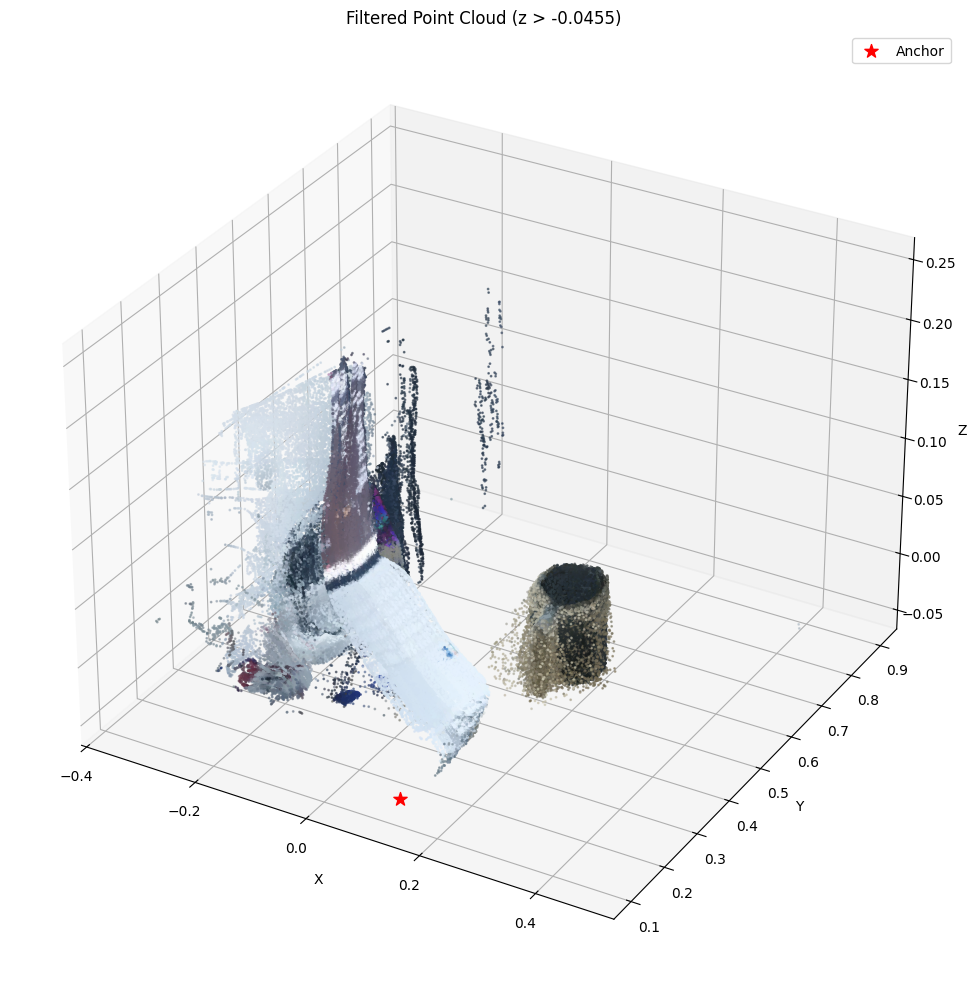

저장 완료: /data/ephemeral/home/measure_volume_by_multiview/project/output/scene_on_anchor.glb
저장된 포인트 수: 254891
시각화와 동일한 데이터로 저장되었습니다.


In [25]:
#앵커기반 필터링 시각화화

import json
import trimesh
import numpy as np
from scipy.spatial.transform import Rotation

# 방법 1: load_jsonl 함수 사용 (이미 노트북에 정의되어 있다면)
frames = load_jsonl(jsonl_path)

# anchor_pos가 있는 첫 번째 프레임 찾기
first_frame = None
for frame in frames:
    if 'anchor_pos' in frame:
        first_frame = frame
        break

if first_frame is None:
    raise ValueError("anchor_pos를 가진 프레임을 찾을 수 없습니다.")

# 앵커 정보 추출
anchor_pos_arcore = np.array(first_frame['anchor_pos'])
anchor_quat_arcore = np.array(first_frame['anchor_quat'])
first_frame_params = {
    'pos': first_frame['pos'],
    'quat': first_frame['quat']
}

print(f"첫 프레임 찾음: t_ns={first_frame.get('t_ns', 'N/A')}")
print(f"앵커 위치 (ARCore): {anchor_pos_arcore}")

# 씬 로드 (방법 1: 직접 로드)
scene = trimesh.load(scene_path)
scene_metadata = scene.metadata

# 중력 정렬 (load_and_align_scene의 변환 부분만 사용)
A = np.array(scene_metadata.get('hf_alignment', np.eye(4))).reshape(4, 4)
gl_to_cv = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
arcore_y = np.array([0, 1, 0])
gravity = (A[:3, :3] @ gl_to_cv @ arcore_y)
gravity = gravity / np.linalg.norm(gravity)

R = Rotation.align_vectors([[0, 0, 1]], [gravity])[0]
T = np.eye(4)
T[:3, :3] = R.as_matrix()

for geom in scene.geometry.values():
    geom.apply_transform(T)

# 앵커 위치를 씬 좌표계로 변환
anchor_pos_scene = transform_point_from_arcore(
    anchor_pos_arcore,
    first_frame_params,
    scene_metadata
)

print(f"앵커 위치 (씬 좌표계): {anchor_pos_scene}")

# 앵커 z 좌표
anchor_z = anchor_pos_scene[2]

# 포인트 클라우드의 bounds 계산
all_vertices = []
for geom in scene.geometry.values():
    if isinstance(geom, trimesh.PointCloud):
        all_vertices.append(geom.vertices)
    elif hasattr(geom, 'vertices'):
        all_vertices.append(geom.vertices)

if len(all_vertices) == 0:
    raise ValueError("씬에 버텍스가 없습니다.")

all_vertices = np.vstack(all_vertices)
scene_bounds = np.array([all_vertices.min(axis=0), all_vertices.max(axis=0)])
scene_min_y = scene_bounds[0, 1]  # Y 최소값 (바닥)
scene_center = scene_bounds.mean(axis=0)

# 씬을 앵커 위치로 이동
translation = np.array([
    anchor_pos_scene[0] - scene_center[0],
    anchor_pos_scene[1] - scene_min_y,  # 바닥을 앵커 Y 위치로
    anchor_pos_scene[2] - scene_center[2]
])

transform_matrix = np.eye(4)
transform_matrix[:3, 3] = translation

# 각 지오메트리에 변환 적용
for geom in scene.geometry.values():
    if hasattr(geom, 'apply_transform'):
        geom.apply_transform(transform_matrix)

# z > anchor_z인 부분만 필터링 (포인트 클라우드)
filtered_geometries = []
for name, geom in scene.geometry.items():
    if isinstance(geom, trimesh.PointCloud):
        # 포인트 클라우드 필터링
        mask = geom.vertices[:, 2] > anchor_z
        if np.any(mask):
            filtered_vertices = geom.vertices[mask]
            filtered_geom = trimesh.PointCloud(vertices=filtered_vertices)
            
            # 색상 정보 복사 (있는 경우)
            if hasattr(geom, 'colors') and geom.colors is not None:
                filtered_geom.colors = geom.colors[mask]
            
            filtered_geometries.append((name, filtered_geom))
            print(f"{name}: {len(geom.vertices)} -> {len(filtered_vertices)} 포인트")
    elif isinstance(geom, trimesh.Trimesh):
        # 메시도 처리 (혹시 있을 경우)
        mask = geom.vertices[:, 2] > anchor_z
        if np.any(mask):
            vertex_indices = np.where(mask)[0]
            vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(vertex_indices)}
            filtered_vertices = geom.vertices[mask]
            
            valid_faces = []
            for face in geom.faces:
                if all(v in vertex_map for v in face):
                    new_face = [vertex_map[v] for v in face]
                    valid_faces.append(new_face)
            
            if len(valid_faces) > 0:
                filtered_geom = trimesh.Trimesh(
                    vertices=filtered_vertices,
                    faces=np.array(valid_faces)
                )
                if hasattr(geom.visual, 'material'):
                    filtered_geom.visual.material = geom.visual.material
                filtered_geometries.append((name, filtered_geom))

# 필터링된 포인트 클라우드로 새 씬 생성
if len(filtered_geometries) == 0:
    raise ValueError("필터링 후 남은 지오메트리가 없습니다.")

filtered_scene = trimesh.Scene()
for name, geom in filtered_geometries:
    filtered_scene.add_geometry(geom, node_name=name)

# 전체 포인트 수 계산
total_points_before = sum(len(geom.vertices) for geom in scene.geometry.values() if isinstance(geom, trimesh.PointCloud))
total_points_after = sum(len(geom.vertices) for geom in filtered_scene.geometry.values() if isinstance(geom, trimesh.PointCloud))

print(f"\n필터링 전 포인트 수: {total_points_before}")
print(f"필터링 후 포인트 수: {total_points_after}")
print(f"앵커 z 좌표: {anchor_z:.6f}")

# 시각화에 사용할 데이터 준비 (matplotlib과 동일)
all_filtered_points = []
all_colors = []

for name, geom in filtered_scene.geometry.items():
    if isinstance(geom, trimesh.PointCloud):
        all_filtered_points.append(geom.vertices)
        if hasattr(geom, 'colors') and geom.colors is not None:
            all_colors.append(geom.colors)

if len(all_filtered_points) > 0:
    # matplotlib 시각화와 동일한 데이터
    combined_points = np.vstack(all_filtered_points)
    
    # 시각화 (포인트 클라우드)
    try:
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D
        
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # 색상이 있으면 사용, 없으면 기본 색상
        if len(all_colors) > 0:
            combined_colors = np.vstack(all_colors)
            # 색상을 0-1 범위로 정규화 (0-255에서 변환)
            if combined_colors.max() > 1.0:
                combined_colors = combined_colors / 255.0
            ax.scatter(
                combined_points[:, 0],
                combined_points[:, 1],
                combined_points[:, 2],
                c=combined_colors,
                s=1,
                alpha=0.6
            )
        else:
            ax.scatter(
                combined_points[:, 0],
                combined_points[:, 1],
                combined_points[:, 2],
                s=1,
                alpha=0.6,
                c='blue'
            )
        
        # 앵커 위치 표시
        ax.scatter(
            anchor_pos_scene[0],
            anchor_pos_scene[1],
            anchor_pos_scene[2],
            s=100,
            c='red',
            marker='*',
            label='Anchor'
        )
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Filtered Point Cloud (z > {anchor_z:.4f})')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"시각화 오류: {e}")
    
    # GLB 저장: 시각화와 동일한 데이터 사용
    # 포인트 클라우드를 하나로 합쳐서 저장
    if len(all_colors) > 0:
        combined_colors_array = np.vstack(all_colors)
        # 색상이 0-255 범위인지 확인하고 정규화
        if combined_colors_array.max() > 1.0:
            combined_colors_array = combined_colors_array.astype(np.uint8)
        else:
            combined_colors_array = (combined_colors_array * 255).astype(np.uint8)
        
        # 색상이 RGBA인지 RGB인지 확인
        if combined_colors_array.shape[1] == 4:
            # RGBA인 경우
            final_pointcloud = trimesh.PointCloud(
                vertices=combined_points,
                colors=combined_colors_array
            )
        else:
            # RGB인 경우, RGBA로 변환
            rgba_colors = np.ones((len(combined_colors_array), 4), dtype=np.uint8) * 255
            rgba_colors[:, :3] = combined_colors_array
            final_pointcloud = trimesh.PointCloud(
                vertices=combined_points,
                colors=rgba_colors
            )
    else:
        final_pointcloud = trimesh.PointCloud(vertices=combined_points)
    
    # Scene으로 만들어서 저장
    final_scene = trimesh.Scene()
    final_scene.add_geometry(final_pointcloud, node_name='filtered_pointcloud')
    
    # GLB로 저장
    final_scene.export(output_path)
    print(f"저장 완료: {output_path}")
    print(f"저장된 포인트 수: {len(combined_points)}")
    print(f"시각화와 동일한 데이터로 저장되었습니다.")
    
else:
    raise ValueError("필터링 후 남은 포인트가 없습니다.")

In [26]:
# 중력방향 정렬
import trimesh
import numpy as np
from scipy.spatial.transform import Rotation

# GLB 로드
scene = trimesh.load('/data/ephemeral/home/measure_volume_by_multiview/project/output/scene_on_anchor.glb')




# 렌더링 확인
# 축 길이 설정
axis_length = 1

# 원점 (0, 0, 0) 사용
origin = np.array([0, 0, 0])

# 원점 (0, 0, 0)에 포인트 생성
# 방법 1: 작은 구(sphere) 사용
origin_point = trimesh.creation.icosphere(radius=0.02)  # 반지름 0.01
origin_point.apply_translation([0, 0, 0])  # 원점으로 이동
origin_point.visual.face_colors = [255, 255, 0, 255]  # 노란색


# X축 (빨강)
x_line = trimesh.creation.cylinder(radius=0.0005, height=axis_length)
x_line.apply_transform(trimesh.transformations.rotation_matrix(
    np.pi/2, [0, 1, 0], [0, 0, 0]
))
x_line.apply_translation(origin + [axis_length/2, 0, 0])  # 원점 기준
x_line.visual.face_colors = [255, 0, 0, 255]

# Y축 (초록)
y_line = trimesh.creation.cylinder(radius=0.0005, height=axis_length)
y_line.apply_transform(trimesh.transformations.rotation_matrix(
    -np.pi/2, [1, 0, 0], [0, 0, 0]
))
y_line.apply_translation(origin + [0, axis_length/2, 0])  # 원점 기준
y_line.visual.face_colors = [0, 255, 0, 255]

# Z축 (파랑)
z_line = trimesh.creation.cylinder(radius=0.0005, height=axis_length)
z_line.apply_translation(origin + [0, 0, axis_length/2])  # 원점 기준
z_line.visual.face_colors = [0, 0, 255, 255]

# 씬에 추가
scene.add_geometry([x_line, y_line, z_line,origin_point])
scene.show()